In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.ticker as mtick
import statsmodels.api as sm

In [2]:
base_path = os.path.join(os.getcwd(), '..', 'steam-insights-main')

games_df_path = os.path.join(base_path, 'games.csv')
genres_path = os.path.join(base_path, 'genres.csv')
steamspy_insights_path = os.path.join(base_path, 'steamspy_insights.csv')
tags_path = os.path.join(base_path, 'tags.csv')
reviews_path = os.path.join(base_path, 'reviews.csv')

In [3]:
# Read games.csv (only app_id and name) and drop rows with missing name
games = pd.read_csv(
    games_df_path,
    usecols=["app_id", "name", "release_date"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip'
)
games = games.dropna(subset=['name'])


# Price and appID from steamspy
steamspy = pd.read_csv(
    steamspy_insights_path,
    usecols=["app_id", "price"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
# Immediately drop rows with missing values in 'price'
steamspy = steamspy.dropna(subset=['price'])
# Replace 'N' in the 'price' column with NaN
steamspy['price'] = steamspy['price'].replace('N', np.nan)
# Convert price to numeric and handle any invalid entries as NaN
steamspy['price'] = pd.to_numeric(steamspy['price'], errors='coerce')
# Drop rows with NaN in 'price' after conversion
steamspy = steamspy.dropna(subset=['price'])
# Adjust price (divide by 100 to get price in euros)
steamspy['price'] = steamspy['price'] / 100



# Read tags.csv (only app_id and tag) and drop rows with missing tag - might need to group by appID to collect all tags together
tags_df = pd.read_csv(
    tags_path,
    usecols=["app_id", "tag"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
tags_df = tags_df.dropna(subset=['tag'])


# Read genres.csv (only app_id and genre) and drop rows with missing genre
genres_df = pd.read_csv(
    genres_path,
    usecols=["app_id", "genre"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
genres_df = genres_df.dropna(subset=['genre'])
# Group tags by app_id, joining multiple tags into one string
tags = tags_df.groupby("app_id")["tag"].apply(lambda x: ", ".join(x.astype(str))).reset_index()
# Group genres by app_id, joining multiple genres into one string
genres = genres_df.groupby("app_id")["genre"].apply(lambda x: ", ".join(x.astype(str))).reset_index()



# Read reviews.csv and drop rows with missing genre
reviews = pd.read_csv(
    reviews_path,
    usecols=["app_id", "review_score", "positive", "negative", "total"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
reviews['review_score'] = pd.to_numeric(reviews['review_score'].replace('N', 0), errors='coerce').fillna(0)
reviews = reviews.dropna(subset=['review_score', 'positive', 'negative', 'total'])


In [4]:
# Merge games and steamspy with an inner join so that only games present in both are kept
df_merged = pd.merge(games, steamspy, on="app_id", how="inner")

# Merge with grouped tags and genres (left join so that if a game lacks tags/genres, it still remains)
df_merged = pd.merge(df_merged, tags, on="app_id", how="left")
df_merged = pd.merge(df_merged, genres, on="app_id", how="left")

# Fill missing values in tag and genre with default values
df_merged['tag'] = df_merged['tag'].fillna('No Tags')
df_merged['genre'] = df_merged['genre'].fillna('No Genre')

df_merged = pd.merge(df_merged, reviews, on="app_id", how="inner")

display(df_merged.head())
print(f"Total rows in merged data: {df_merged.shape[0]}")

,app_id,name,release_date,price,tag,genre,review_score,positive,negative,total
0,10,Counter-Strike,2000-11-01,9.99,"1980s, 1990's, Action, Assassin, Classic, Comp...",Action,9,235403,6207,241610
1,20,Team Fortress Classic,1999-04-01,4.99,"1990's, Action, Class-Based, Classic, Co-op, C...",Action,8,7315,1094,8409
2,30,Day of Defeat,2003-05-01,4.99,"Action, Class-Based, Classic, Co-op, Difficult...",Action,8,6249,672,6921
3,40,Deathmatch Classic,2001-06-01,4.99,"1990's, Action, Arena Shooter, Classic, Co-op,...",Action,8,2542,524,3066
4,50,Half-Life: Opposing Force,1999-11-01,4.99,"1990's, Action, Adventure, Aliens, Atmospheric...",Action,9,22263,1111,23374


Total rows in merged data: 90890


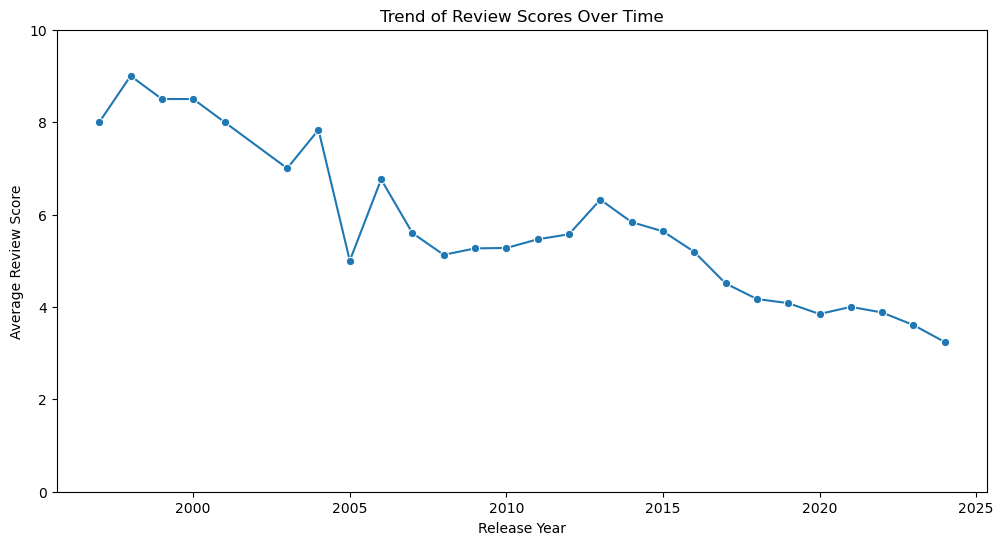

In [11]:
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='review_score', data=yearly_reviews, marker='o')
plt.xlabel("Release Year")
plt.ylabel("Average Review Score")
plt.title("Trend of Review Scores Over Time")
plt.ylim(0, 10)
plt.show()


# See how review scores have evolved over the years.


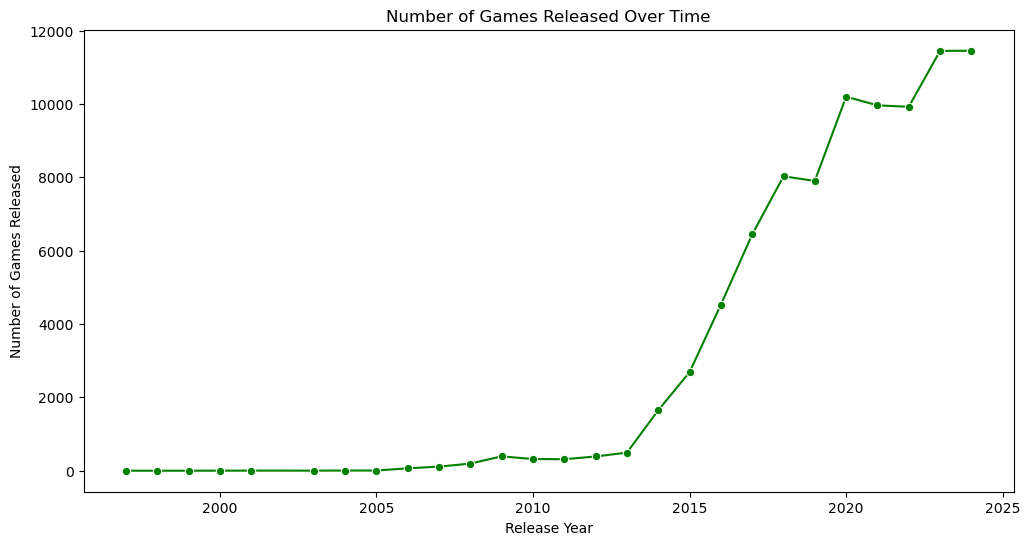

In [11]:
# Show the number of games released each year
# Maybe also show the number of games above and below the average review score for each year.
# Might work as a bar graph?

# x axis = year
# y axis = number of games
# stacked bar graph
# one stack is games with review score above average
# other stack is games with review score below average

# Count number of games released each year
yearly_game_counts = df_merged.groupby('release_year').size().reset_index(name='num_games')

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='num_games', data=yearly_game_counts, marker='o', color='green')
plt.xlabel("Release Year")
plt.ylabel("Number of Games Released")
plt.title("Number of Games Released Over Time")
plt.show()





Average Review Score for all games: 4.07


<Figure size 1200x600 with 0 Axes>

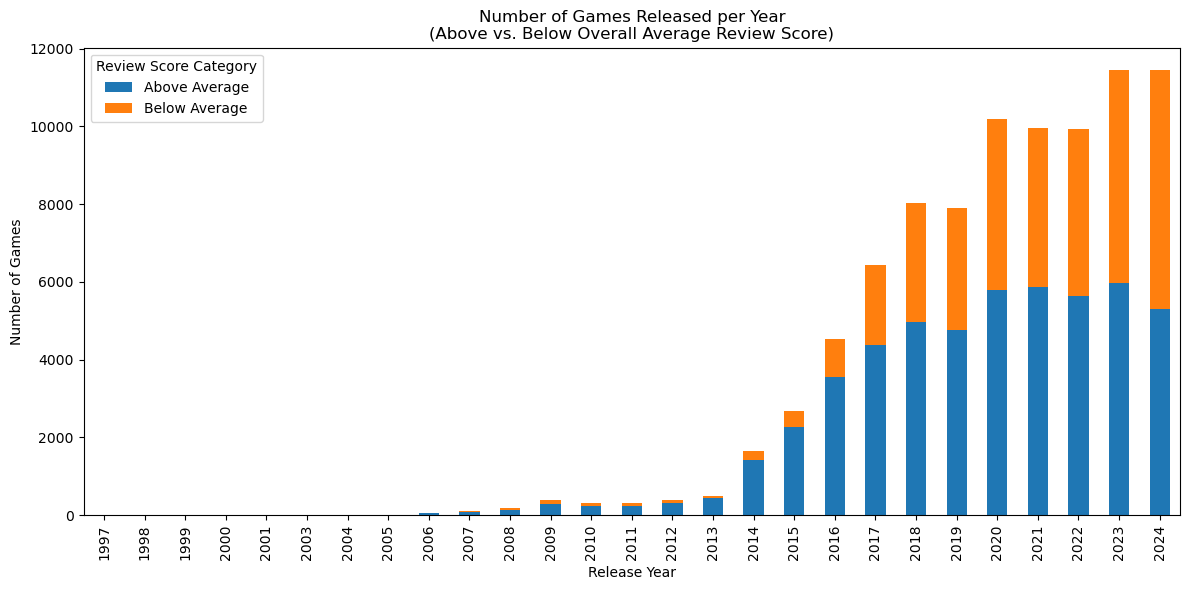

In [12]:
# Assume df_merged already has the 'review_score' and 'release_date' columns
# Convert release_date to datetime and drop invalid ones
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged = df_merged.dropna(subset=['release_date'])
df_merged['release_year'] = df_merged['release_date'].dt.year

# Calculate the overall average review score
avg_review = df_merged['review_score'].mean()
print(f"Average Review Score for all games: {avg_review:.2f}")

# Categorize games based on the average review score
df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

# Group by release_year and score_category and count the number of games
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

# Pivot the table so that each year is a row and the categories are columns
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)

# Sort the index for a chronological order
yearly_pivot = yearly_pivot.sort_index()

# Plot a stacked bar graph
plt.figure(figsize=(12, 6))
yearly_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Number of Games Released per Year\n(Above vs. Below Overall Average Review Score)")
plt.legend(title="Review Score Category")
plt.tight_layout()
plt.show()


In [13]:
# Quality vs Quantity

# Overall average review score 
avg_review = df_merged['review_score'].mean()
print(f"Overall Average Review Score: {avg_review:.2f}")


Overall Average Review Score: 4.07


In [14]:
# Label each game
df_merged['score_category'] = df_merged['review_score'].apply(lambda x: 'Above Average' if x >= avg_review else 'Below Average')

# Group by release year and score category
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')

# Pivot for a stacked bar plot
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot.sort_index()

display(yearly_pivot.head(30))



score_category,Above Average,Below Average
release_year,,
1997,2.0,0.0
1998,1.0,0.0
1999,2.0,0.0
2000,2.0,0.0
2001,4.0,0.0
2003,3.0,0.0
2004,6.0,0.0
2005,4.0,2.0
2006,61.0,6.0


<Figure size 1200x600 with 0 Axes>

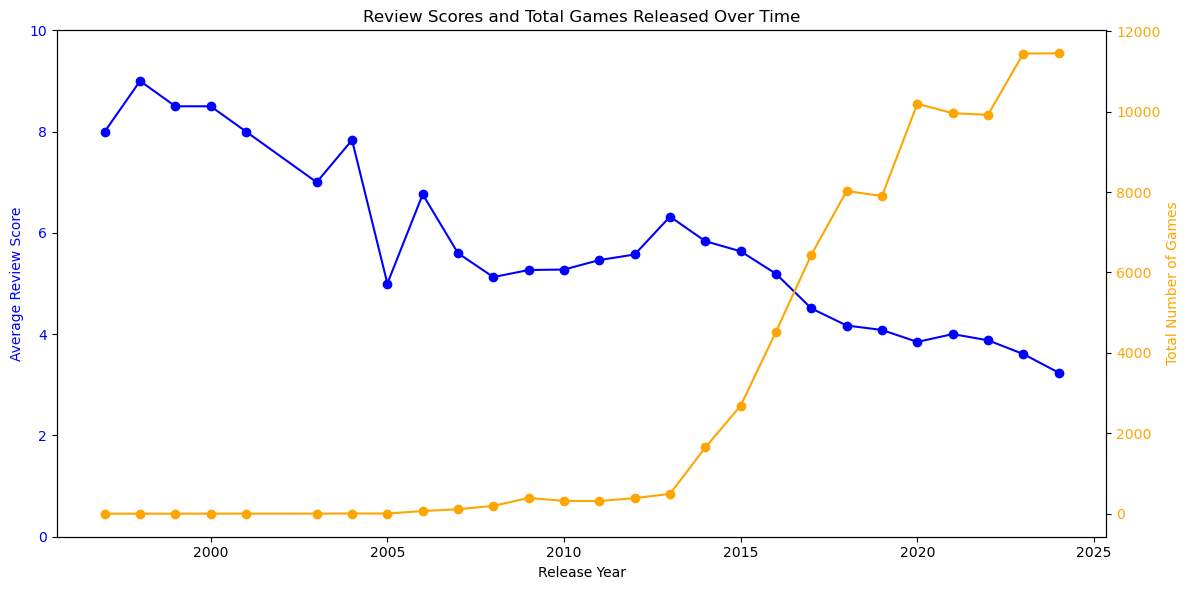

In [18]:
# Average review score per year
yearly_reviews = df_merged.groupby('release_year')['review_score'].mean().reset_index()
total_games = df_merged.groupby('release_year').size().reset_index(name='total_games')

plt.figure(figsize=(12, 6))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average review score on primary y-axis
ax1.set_xlabel("Release Year")
ax1.set_ylabel("Average Review Score", color='blue')
ax1.plot(yearly_reviews['release_year'], yearly_reviews['review_score'], marker='o', color='blue', label="Average Review Score")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 10)

# Create a secondary y-axis for total number of games
ax2 = ax1.twinx()
ax2.set_ylabel("Total Number of Games", color='orange')
ax2.plot(total_games['release_year'], total_games['total_games'], marker='o', color='orange', label="Total Number of Games")
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Review Scores and Total Games Released Over Time")
fig.tight_layout()
plt.show()


# Price vs. Review Trend:
# As you noted, recent years show a 50/50 split of games above and below the overall average review score.
# This may indicate market saturation with lower-quality games impacting the overall review average.

# Release Volume:
# The dramatic increase in the number of games (from fewer than 2000 to over 11,000 per year) 
# might be contributing to the drop in average review scores if many new games have lower ratings.


In [19]:

# Suppose you have a DataFrame 'total_games' with columns 'release_year' and 'total_games'
# For example, it could be created like this:
# total_games = df_merged.groupby('release_year').size().reset_index(name='total_games')

# Prepare the feature and target arrays
X = total_games['release_year'].values.reshape(-1, 1)  # Independent variable: release year
y = total_games['total_games'].values                 # Dependent variable: total number of games

# Fit the linear regression model
lin_reg = LinearRegression().fit(X, y)
print("Coefficient:", lin_reg.coef_[0])
print("Intercept:", lin_reg.intercept_)

# Predict for future years, e.g., 2024 to 2028
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
predictions = lin_reg.predict(future_years)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'release_year': future_years.flatten(), 'predicted_total_games': predictions})
print(forecast_df)


Coefficient: 455.2856508688116
Intercept: -912291.0947025748
   release_year  predicted_total_games
0          2024            9207.062656
1          2025            9662.348307
2          2026           10117.633958
3          2027           10572.919609
4          2028           11028.205259


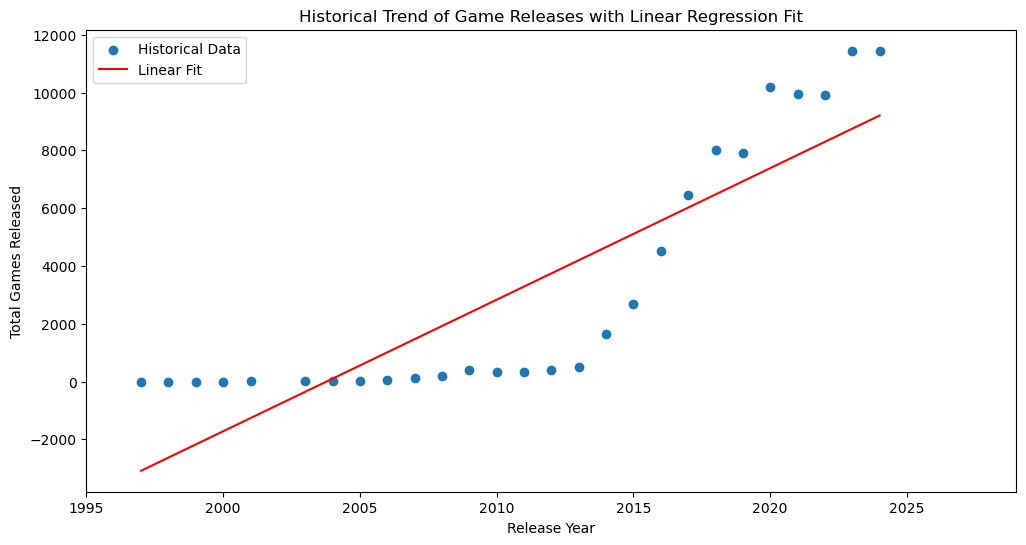

In [20]:

plt.figure(figsize=(12,6))
plt.scatter(total_games['release_year'], total_games['total_games'], label='Historical Data')
plt.plot(total_games['release_year'], lin_reg.predict(X), color='red', label='Linear Fit')
plt.xlabel('Release Year')
plt.ylabel('Total Games Released')
plt.title('Historical Trend of Game Releases with Linear Regression Fit')
plt.xlim(1995, 2029)
plt.legend()
plt.show()


g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stati

                               SARIMAX Results                                
Dep. Variable:            total_games   No. Observations:                   27
Model:                 ARIMA(8, 1, 0)   Log Likelihood                -201.399
Date:                Wed, 26 Mar 2025   AIC                            420.798
Time:                        18:13:23   BIC                            432.121
Sample:                             0   HQIC                           424.058
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1071      0.331      0.324      0.746      -0.541       0.755
ar.L2          0.6516      0.483      1.349      0.177      -0.295       1.599
ar.L3          0.5795      0.376      1.539      0.1

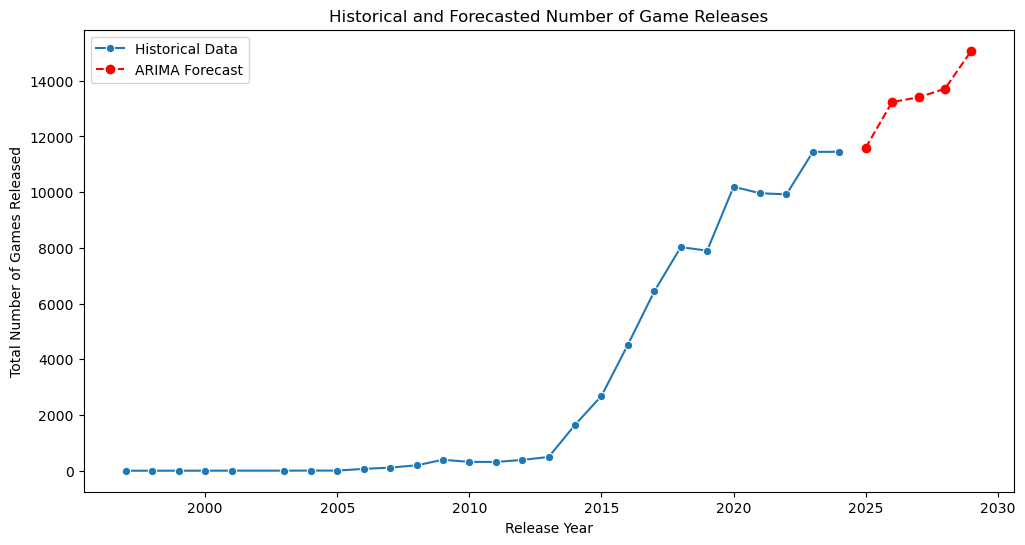

In [21]:
# Maybe mention in report that linear regression is not the best model here, as its prediction was below previous year values. 


# Set release_year as index for time series modeling
total_games_ts = total_games.set_index('release_year')['total_games']

# Fit an ARIMA model. 
# You might need to experiment with the order parameter (p,d,q). Here we try (1,1,1) as a starting point.
model = sm.tsa.ARIMA(total_games_ts, order=(8, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

# Forecast for future years, e.g., next 5 years.
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)
forecast_years = np.arange(total_games_ts.index.max()+1, total_games_ts.index.max()+forecast_steps+1)

# Create DataFrame for forecast results
forecast_df = pd.DataFrame({'release_year': forecast_years, 'predicted_total_games': forecast})
print(forecast_df)

# Plot historical data and ARIMA forecast
plt.figure(figsize=(12, 6))
sns.lineplot(x=total_games['release_year'], y=total_games['total_games'], marker='o', label='Historical Data')
plt.plot(forecast_df['release_year'], forecast_df['predicted_total_games'], marker='o', linestyle='--', color='red', label='ARIMA Forecast')
plt.xlabel("Release Year")
plt.ylabel("Total Number of Games Released")
plt.title("Historical and Forecasted Number of Game Releases")
plt.legend()
plt.show()

In [22]:
# --- Step 1: Prepare the Historical Data ---
# Assuming df_merged has 'release_year' and 'score_category' ('Above Average' / 'Below Average')
# Group by release_year and score_category to get counts, then pivot for a stacked table:
yearly_counts = df_merged.groupby(['release_year', 'score_category']).size().reset_index(name='num_games')
yearly_pivot = yearly_counts.pivot(index='release_year', columns='score_category', values='num_games').fillna(0)
yearly_pivot = yearly_pivot.sort_index()

# Display historical stacked counts:
print("Historical counts per year:")
print(yearly_pivot)


Historical counts per year:
score_category  Above Average  Below Average
release_year                                
1997                      2.0            0.0
1998                      1.0            0.0
1999                      2.0            0.0
2000                      2.0            0.0
2001                      4.0            0.0
2003                      3.0            0.0
2004                      6.0            0.0
2005                      4.0            2.0
2006                     61.0            6.0
2007                     87.0           25.0
2008                    141.0           55.0
2009                    296.0           97.0
2010                    238.0           81.0
2011                    249.0           66.0
2012                    309.0           80.0
2013                    452.0           42.0
2014                   1413.0          236.0
2015                   2261.0          426.0
2016                   3544.0          983.0
2017                   4383

In [24]:
# --- Step 2: Fit ARIMA Models to Each Series ---
# Define forecast horizon (e.g., next 5 years)
future_steps = 5
last_year = yearly_pivot.index.max()
future_years = np.arange(last_year+1, last_year+1+future_steps)

# Extract time series for each category
# If a category is missing for some years, the pivot table already filled with 0
above_ts = yearly_pivot['Above Average']
below_ts = yearly_pivot['Below Average']

# Fit ARIMA for Above Average (using order=(1,1,1) as a starting point)
model_above = sm.tsa.ARIMA(above_ts, order=(1,1,1))
model_above_fit = model_above.fit()
forecast_above = model_above_fit.forecast(steps=future_steps)

# Fit ARIMA for Below Average
model_below = sm.tsa.ARIMA(below_ts, order=(1,1,1))
model_below_fit = model_below.fit()
forecast_below = model_below_fit.forecast(steps=future_steps)

g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programs\MiniConda\envs\fds-cw2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported

In [25]:
# --- Step 3: Combine Forecasts and Compute Percentages ---
forecast_df = pd.DataFrame({
    'release_year': future_years,
    'predicted_above': forecast_above,
    'predicted_below': forecast_below
})
forecast_df['total_predicted'] = forecast_df['predicted_above'] + forecast_df['predicted_below']
forecast_df['pct_above'] = (forecast_df['predicted_above'] / forecast_df['total_predicted']) * 100
forecast_df['pct_below'] = (forecast_df['predicted_below'] / forecast_df['total_predicted']) * 100

print("\nForecasted counts and percentages:")
print(forecast_df)


Forecasted counts and percentages:
    release_year  predicted_above  predicted_below  total_predicted  \
27          2025      5086.089625      6662.011017     11748.100641   
28          2026      4908.274043      7160.920298     12069.194341   
29          2027      4765.791381      7638.665417     12404.456799   
30          2028      4651.620796      8096.144178     12747.764974   
31          2029      4560.136525      8534.216296     13094.352821   

    pct_above  pct_below  
27  43.292867  56.707133  
28  40.667785  59.332215  
29  38.419993  61.580007  
30  36.489697  63.510303  
31  34.825215  65.174785  


<Figure size 1400x700 with 0 Axes>

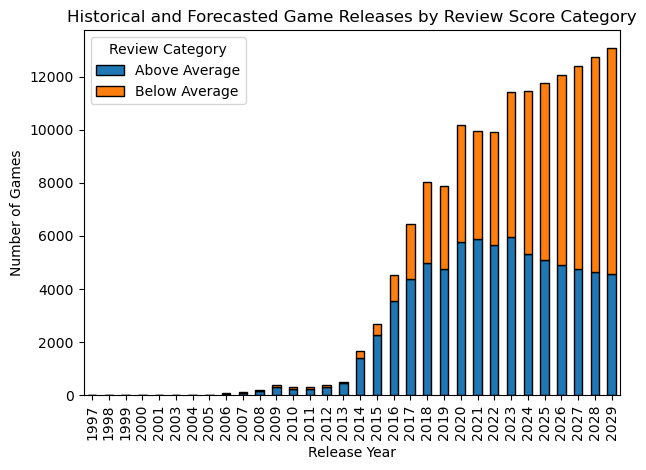

In [26]:
# Assume yearly_pivot is your historical DataFrame with release_year as index and columns "Above Average" and "Below Average"
# For forecast, rename the columns in forecast_df so they match:
future_df = forecast_df.copy()
future_df = future_df.set_index('release_year')[['predicted_above', 'predicted_below']]
future_df.columns = ['Above Average', 'Below Average']

# Combine historical and forecasted data into one DataFrame:
combined_df = pd.concat([yearly_pivot, future_df]).sort_index()

# Plot a stacked bar chart for the combined data with default colors
plt.figure(figsize=(14,7))
combined_df.plot(kind='bar', stacked=True, edgecolor='black')  # No manual color mapping
plt.xlabel("Release Year")
plt.ylabel("Number of Games")
plt.title("Historical and Forecasted Game Releases by Review Score Category")
plt.legend(title='Review Category')
plt.tight_layout()
plt.show()

# find correlation between release year and review score for statistical analysis - it needs to be backed up with evidence - some sort of test
# as the number of games each year increases, the ratio between above average games and below average games decreases - alternate hypothesis
# Null hyptothese - the number of games released each year does not affect the ratio of above average games to below average games.

In [ ]:
# Graph to use:
# Trend over time (line graph): average review score with no. games release per year
# Stacked bar graph of game releases by quantity of review score above/below average
# Arima forecast with comparison to linear regression

In [15]:
import statsmodels.api as sm

# Group by year and count total games
total_games_per_year = df_merged.groupby('release_year').size().rename('total_games')

# Calculate proportion of above-average games per year
avg_review = df_merged['review_score'].mean()
above_avg_per_year = df_merged[df_merged['review_score'] >= avg_review].groupby('release_year').size().rename('above_avg_games')

# Merge into a single DataFrame
yearly_data = pd.DataFrame({'total_games': total_games_per_year, 'above_avg_games': above_avg_per_year}).fillna(0)

# Calculate proportion of above-average games
yearly_data['prop_above'] = yearly_data['above_avg_games'] / yearly_data['total_games']

# Drop years with no total games (if any)
yearly_data = yearly_data.dropna().reset_index()

# Now run the regression
X = sm.add_constant(yearly_data['total_games'])
model = sm.OLS(yearly_data['prop_above'], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             prop_above   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     57.06
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           6.58e-08
Time:                        18:56:19   Log-Likelihood:                 25.919
No. Observations:                  27   AIC:                            -47.84
Df Residuals:                      25   BIC:                            -45.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8898      0.023     38.319      